# Journal Profiling Part 5: Competing Journals Analysis

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to create a competitive journals analysis report, starting from a specific journal and by using its authors information. 

This tutorial is the fifth of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the researchers impact metrics data previously extracted (see parts 1-2-3)
* Get the full publications history for these researchers 
* Use this new publications dataset to determine which are the most frequent journals the researchers have also published in
* Build some visualizations in order to have a quick overview of the results 

In [12]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


Finally, let's set up a folder to store the data we are going to extract: 

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)

def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Competing Journals

From our researchers master list, we now want to extract the following:

* full list of publications for a N year period
* full list of journals with counts of how many publications per journal 

This new dataset will let us draw up some conclusions re. which are the competing journals of the one we selected at the beginning.



### First let's reload the data obtained in previous steps

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `2_researchers_impact_metrics.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [3]:
#
researchers = pd.read_csv(FOLDER_NAME+"/2_researchers_impact_metrics.csv")
#
print("Total researchers:", len(researchers))
researchers.head(5)

Total researchers: 23346


researcher_id  pubs               full_name  citations_mean  \
0    ur.0723426172.10    77         Kari Stefansson      201.493506   
1   ur.01277776417.51    51  Unnur Thorsteinsdottir      131.862745   
2    ur.0641525362.39    42     Gonçalo R. Abecasis      223.714286   
3  ur.011675454737.09    39    Cornelia M van Duijn      216.102564   
4   ur.01264737414.70    39               Tõnu Esko      244.564103   

   altmetric_mean  last_pub_year  url  
0      248.818182           2021  NaN  
1      201.666667           2021  NaN  
2      167.809524           2021  NaN  
3      303.179487           2021  NaN  
4      339.923077           2021  NaN

In [4]:
# TIP to speed this up I'm taking only the top 2000 researchers!
# for a full analysis, just comment out the next line
researchers = researchers[:2000]

### What the query looks like

The approach we're taking consists in pulling all publications data, so that we can count journals as a second step. 

This approach may take some time (as we're potentially retrieving a lot of publications data), but it will lead to precise results.  

The query template to use looks like this (for a couple of researchers only):

In [5]:
%%dsldf 
search publications where researchers.id in ["ur.01277776417.51", "ur.0637651205.48"] 
    and year >= 2015 and journal is not empty 
    and journal.id != "jour.1103138" 
return publications[id+journal] limit 10

Returned Publications: 10 (total = 209)
Time: 0.62s


id    journal.id  \
0  pub.1144294896  jour.1044693   
1  pub.1144045413  jour.1100952   
2  pub.1144018365  jour.1369542   
3  pub.1143745202  jour.1018957   
4  pub.1143816650  jour.1293558   
5  pub.1143538243  jour.1041454   
6  pub.1142697518  jour.1293558   
7  pub.1142590280  jour.1045682   
8  pub.1141693039  jour.1300829   
9  pub.1138032051  jour.1399822   

                                      journal.title  
0                                          BMJ Open  
1  Arteriosclerosis Thrombosis and Vascular Biology  
2                                           medRxiv  
3                                            Nature  
4                                           bioRxiv  
5                    Science Translational Medicine  
6                                           bioRxiv  
7                              Blood Cancer Journal  
8                            Communications Biology  
9                          Arthritis & Rheumatology

## Extracting all publications/journals information

This part may take some time to run (depending on how many years back one wants to go) so you may want to get a coffee while you wait.. 


In [6]:
#
journal_id = "jour.1103138" # = Nature Genetics
start_year = 2018

# our list of researchers
llist = list(researchers['researcher_id'])
#
# the query
q2 = """search publications 
            where researchers.id in {} 
            and year >= {} and journal is not empty and journal.id != "{}" 
    return publications[id+journal+year]"""

In [7]:

VERBOSE = True
RESEARCHER_ITERATOR_NO = 400

pubs = pd.DataFrame
for chunk in progress(list(chunks_of(llist, RESEARCHER_ITERATOR_NO))):
    # get all pubs
    query = q2.format(json.dumps(chunk), start_year, journal_id)
    res = dsl.query_iterative(query, verbose=VERBOSE)
    if pubs.empty:
        # first time, init the dataframe         
        pubs = res.as_dataframe()
    else:
        pubs.append(res.as_dataframe())

  0%|          | 0/5 [00:00<?, ?it/s]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 23456 (2.23s)
1000-2000 / 23456 (2.17s)
2000-3000 / 23456 (2.36s)
3000-4000 / 23456 (1.87s)
4000-5000 / 23456 (1.93s)
5000-6000 / 23456 (1.86s)
6000-7000 / 23456 (1.78s)
7000-8000 / 23456 (2.04s)
8000-9000 / 23456 (1.91s)
9000-10000 / 23456 (1.89s)
10000-11000 / 23456 (1.86s)
11000-12000 / 23456 (1.76s)
12000-13000 / 23456 (1.79s)
13000-14000 / 23456 (1.69s)
14000-15000 / 23456 (1.82s)
15000-16000 / 23456 (1.87s)
16000-17000 / 23456 (1.77s)
17000-18000 / 23456 (1.73s)
18000-19000 / 23456 (1.94s)
19000-20000 / 23456 (3.05s)
20000-21000 / 23456 (2.24s)
21000-22000 / 23456 (1.99s)
22000-23000 / 23456 (1.90s)
23000-23456 / 23456 (1.63s)
===
Records extracted: 23456
Starting iteration with limit=1000 skip=0 ...
0-1000 / 21078 (1.98s)
1000-2000 / 21078 (1.98s)
2000-3000 / 21078 (1.99s)
3000-4000 / 21078 (1.75s)
4000-5000 / 21078 (1.81s)
5000-6000 / 21078 (1.85s)
6000-7000 / 21078 (1.84s)
7000-8000 / 21078 (1.95s)
8000-9000 / 21078 (1.77s

In [8]:
# remove duplicate publications, if they have the same PUB_ID
pubs = pubs.drop_duplicates(subset="id")
# preview the data
pubs

id  year    journal.id  \
0      pub.1144058594  2022  jour.1088601   
1      pub.1144115098  2022  jour.1098341   
2      pub.1144111238  2022  jour.1400578   
3      pub.1142542983  2022  jour.1088601   
4      pub.1142207532  2022  jour.1034064   
...               ...   ...           ...   
23451  pub.1101137729  2018  jour.1119070   
23452  pub.1101137719  2018  jour.1119070   
23453  pub.1100924477  2018  jour.1018190   
23454  pub.1100522151  2018  jour.1046789   
23455  pub.1084865232  2018  jour.1101614   

                                  journal.title  
0                                     Maturitas  
1      Journal of Food Composition and Analysis  
2                         Ophthalmology Science  
3                                     Maturitas  
4                   Food Quality and Preference  
...                                         ...  
23451            Journal of Alzheimer's Disease  
23452            Journal of Alzheimer's Disease  
23453   Nederlands Tijdschrift voor Geneeskunde  
23454               Food and Nutrition Sciences  
23455                       European Psychiatry  

[23456 rows x 4 columns]

Now we can create a journals-only dataset that includes counts per year, and grant total. 

In [9]:
journals = pubs.copy()
# drop pub_id column
journals = journals.drop(['id'], axis=1)
# 
# add total column 
journals['total'] = journals.groupby('journal.id')['journal.id'].transform('count')
journals['total_year'] = journals.groupby(['journal.id', 'year'])['journal.id'].transform('count')
# 
# remove multiple counts for same journal
journals = journals.drop_duplicates() 
journals.reset_index(drop=True)
#
# sort by total count
journals = journals.sort_values('total', ascending=False)
# #
# # save
save(journals, "5.competing_journals.csv" )
print("======\nDone")

#preview the data 
journals.head(10)

Done


year    journal.id          journal.title  total  total_year
65     2021  jour.1293558                bioRxiv   1811         320
18024  2018  jour.1293558                bioRxiv   1811         497
5980   2020  jour.1293558                bioRxiv   1811         403
12009  2019  jour.1293558                bioRxiv   1811         591
11999  2019  jour.1369542                medRxiv    994          65
5978   2020  jour.1369542                medRxiv    994         442
18     2021  jour.1369542                medRxiv    994         487
131    2021  jour.1043282  Nature Communications    566         132
6062   2020  jour.1043282  Nature Communications    566         166
18117  2018  jour.1043282  Nature Communications    566         130

## Visualizations

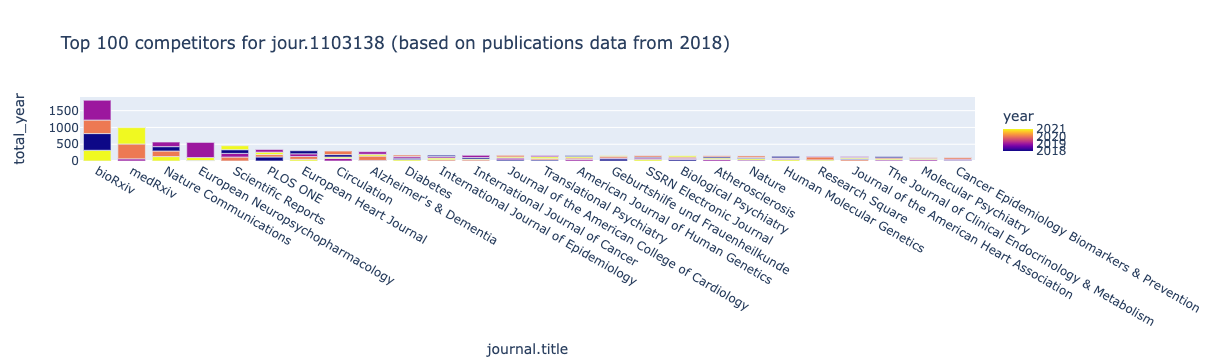

In [10]:

threshold = 100
temp = journals.sort_values("total", ascending=False)[:threshold]

px.bar(journals[:threshold], 
       x="journal.title", y="total_year", 
       color="year",
       hover_name="journal.title", 
       hover_data=['journal.id', 'journal.title', 'total' ], 
       title=f"Top {threshold} competitors for {journal_id} (based on publications data from {start_year})")

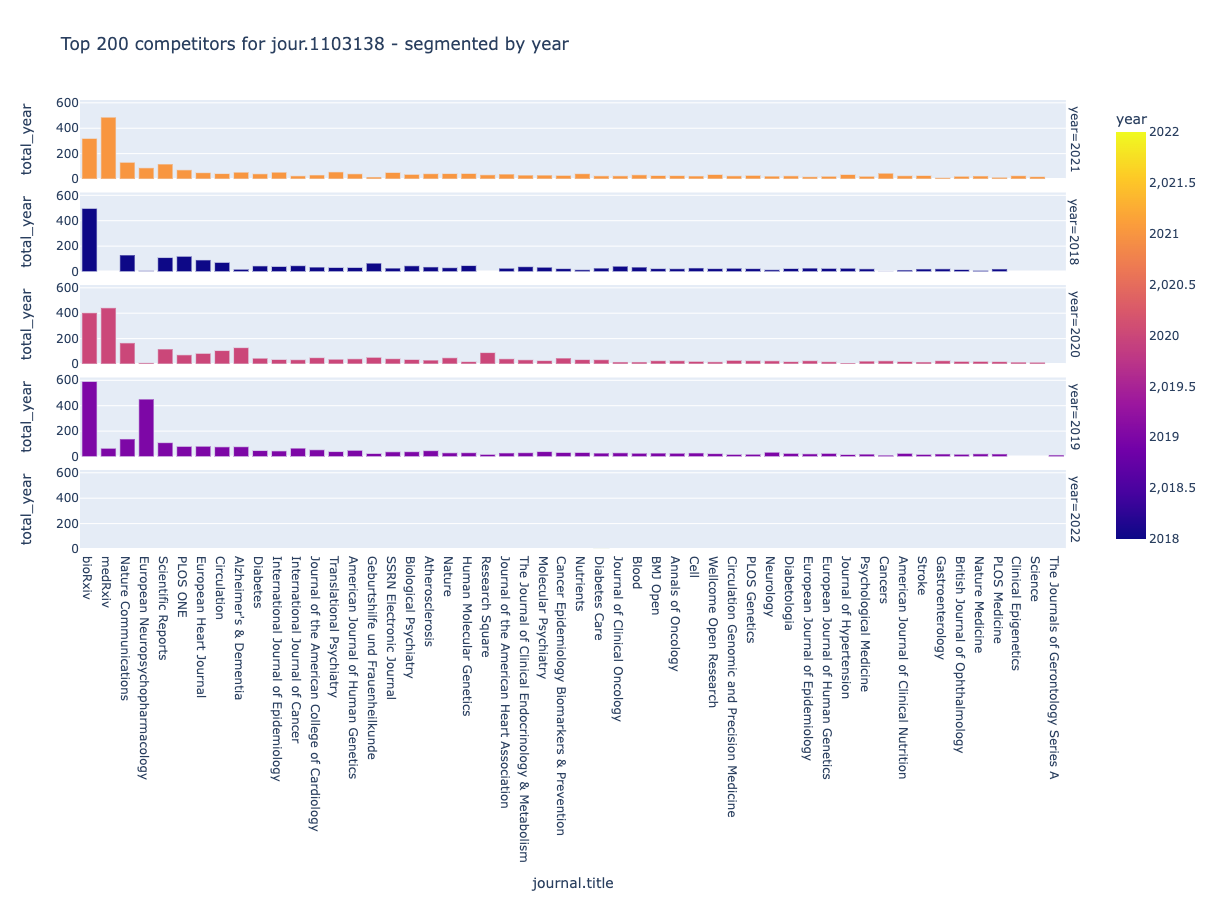

In [11]:
threshold = 200
temp = journals.sort_values("year", ascending=True).groupby("year").head(threshold)

px.bar(journals[:threshold], 
       x="journal.title", y="total_year", 
       color="year",
       facet_row="year",
       height=900,
       hover_name="journal.title", 
       hover_data=['journal.id', 'journal.title', 'total' ], 
       title=f"Top {threshold} competitors for {journal_id} - segmented by year")

NOTE the European Neuropsychopharmacology journal has a massive jump in 2019 cause they [published a lot of conference proceedings](https://www.sciencedirect.com/journal/european-neuropsychopharmacology/issues)! See also the journal [Dimensions page](https://app.dimensions.ai/analytics/publication/overview/timeline?and_facet_source_title=jour.1101548) for comparison.. 
